# This script is is a example of how to apply ROHSA-SNAPD to an observation

We generate a mock IFU cube of Halpha-like emission from a disc galaxy using [KinMS]((https://kinms.space/)) (Davis et al. 2013)

Note that unlike the ROHSA-SNAPD paper, we show here the result of only a single noise realizations, rather than the median of 200 realizations, which means the results are noisier.

# Imports

In [1]:
# make jax 64-bit
from jax import config
config.update('jax_enable_x64', True)

import sys
import os

from kinms import KinMS
from kinms_fitter import velocity_profs, sb_profs
import numpy as np
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling import models, fitting
from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
import astropy.units as u
import astropy.constants as c
from jax import vmap
import jax.numpy as jnp
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../src/ROHSA_SNAPD/')
import ROHSA_SNAPD
from ROHSA_SNAPD_funcs import jnp_convolve_kernel,jnp_bin_data, kin_maps_to_convolved_cube

# Scripts to generate the data

In [2]:
def chosen_cosmo():
    # same cosmology as Wisnioski+2019
    return FlatLambdaCDM(H0=70, Om0=0.3)

def Reff_to_scale_radius(Reff):
    '''
    The GalSim package has a converstion factor to many decimal places as this value is not analytic,
    https://galsim-developers.github.io/GalSim/_build/html/_modules/galsim/exponential.html#Exponential
    :param Reff:
    :return:
    '''
    return Reff/1.6783469900166605

def get_data_scale_factor(data_cube):
    # scale data to have better flux values for the optimiser
    # make flux map from data
    flux_map = np.nansum(data_cube, axis=0)

    # get the 99th percentile of the data
    p99 = np.percentile(flux_map, 99)
    # then scale the data such that the 99th percentile of the flux is 100
    scale_fact = 100 / p99
    return scale_fact

def create_moffat_psf(PSF_shape,amp,beta,FWHM_maj, FWHM_min, PA):
    '''
    Values of PSF_shape and FWHM are assumed to be in units of pixels

    :param amp: The amplitude of the profile
    :param beta: The power index of the profile
    :param FWHM_maj: The major axis FWHM of the profile
    :param FWHM_min: The minor axis FWHM of the profile
    :param PA: The position angle of the profile (in degrees
    :return:
    '''

    # calculate pixel offset from kernel centre (centre distribution on an entire pixel)
    y0 = PSF_shape[0]//2
    x0 = PSF_shape[1]//2

    # convert FWHM to sigma
    # R = FWHM / (2*sqrt(2^(1/beta)-1))
    # as per https://nbviewer.org/github/ysbach/AO_2017/blob/master/04_Ground_Based_Concept.ipynb#1.2.-Moffat
    gamma_maj = FWHM_maj/(2*np.sqrt(2**(1/beta)-1))
    gamma_min = FWHM_min / (2 * np.sqrt(2 ** (1 / beta) - 1))

    # initialise PSF
    psf_im = np.zeros(PSF_shape)

    # a moffat distribution with rotation matrix [xcos(theta) - ysin(theta),xsin(theta) + ycos(theta)]
    # major axis is defined by KMOS along the y-axis
    rotated_moffat_dist = lambda y, x: amp * (1 + ((x * np.cos(np.deg2rad(PA)) - y * np.sin(np.deg2rad(PA))) / gamma_min) ** 2 + ((x * np.sin(np.deg2rad(PA)) + y * np.cos(np.deg2rad(PA))) / gamma_maj) ** 2) ** (-beta)

    for y in range(PSF_shape[0]):
        for x in range(PSF_shape[1]):
            psf_im[y, x] = rotated_moffat_dist(y - y0, x - x0)

    return psf_im

def create_unconvolved_galaxy_cube(gal_pos_ang, gal_inc, gal_redshift,
                   gal_characteristic_vdisp, gal_mass,
                   obs_xsize_arcsec, obs_ysize_arcsec, obs_v_size_kms, obs_xycellsize,
                   obs_vstep_kms,
                   vdisp_profile_type='constant',
                   n_clouds = None,
                   high_res_spatial_oversample_factor=1,
                   high_res_velocity_oversample_factor=1):

    # converting mass and redshift to radius as per van_der_Wel_2014
    vdW2014_z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75]
    vdW2014_logA = [0.86, 0.78, 0.70, 0.65, 0.55, 0.51]
    vdW2014_alpha = [0.25, 0.22, 0.22, 0.23, 0.22, 0.18]

    if gal_redshift < min(vdW2014_z):
        logA = vdW2014_logA[0]
        alpha = vdW2014_alpha[0]
    elif gal_redshift > max(vdW2014_z):
        logA = vdW2014_logA[-1]
        alpha = vdW2014_alpha[-1]
    else:
        # interpolate between the values given redshift of galaxy
        logA_interp_func = interp1d(vdW2014_z, vdW2014_logA)
        alpha_interp_func = interp1d(vdW2014_z, vdW2014_alpha)

        logA = logA_interp_func(gal_redshift)
        alpha = alpha_interp_func(gal_redshift)

    print(f'Identified parameters from van der Wel et al. (2014): log(A)={logA:.3f}, alpha={alpha:.3f}')

    # Reff is the scale radius in Kpc
    Reff = (10 ** logA * (gal_mass / 5e10) ** alpha) * u.kpc
    # convert Reff to arcseconds
    Reff_arcsec = (Reff * chosen_cosmo().arcsec_per_kpc_proper(gal_redshift)).to(u.arcsec).value

    print(f'Galaxy effective radius (arcsec): {Reff_arcsec}')

    # convert to scale radius
    exp_scale_radius = Reff_to_scale_radius(Reff_arcsec)

    print(f'Exponential distribution scale radius (arcsec): {exp_scale_radius}')

    # set max radius to be half the size of the cube (ie. so should be out to the radius)
    b_prof_max_rad_arcsec = np.sqrt(obs_xsize_arcsec**2+obs_ysize_arcsec**2)/2
    gal_radius = np.linspace(start=0, stop=b_prof_max_rad_arcsec, num=100000,endpoint=True)  # radius vector in arcseconds

    # make velocity profile
    # convert redshift to proper distance
    distance = chosen_cosmo().angular_diameter_distance(gal_redshift).to(u.Mpc).value
    v_prof_func = velocity_profs.exponential_disc(distance, [np.log10(gal_mass), exp_scale_radius], minimums=[],
                                             maximums=[], fixed=[True, True])
    v_prof = v_prof_func(gal_radius, theargs=[np.log10(gal_mass), exp_scale_radius])

    # if want non-constant velocity dispersion profile, include
    if vdisp_profile_type != 'constant':
        if vdisp_profile_type == 'linear':
            # make a linear profile from gal_characteristic_vdisp to 0 (must reverse array)
            vdisp_prof = np.linspace(0,gal_characteristic_vdisp,len(gal_radius))[::-1]

        else:
            raise ValueError(f"vdisp_profile_type = '{vdisp_profile_type}' is unknown, should be one of ['constant','linear']")
    else:
        vdisp_prof = gal_characteristic_vdisp

    # make brightness profile
    b_prof_func = sb_profs.expdisk(exp_scale_radius, minimums=[],maximums=[], fixed=[True])
    b_prof = b_prof_func(gal_radius, args=[exp_scale_radius])

    # want to create a high-resolution cube which will then bin spatially and spectrally
    high_res_obs_xycellsize = obs_xycellsize/high_res_spatial_oversample_factor
    high_res_obs_vstep_kms = obs_vstep_kms/high_res_velocity_oversample_factor

    # initialise KinMS object
    kinms = KinMS(obs_xsize_arcsec, obs_ysize_arcsec, obs_v_size_kms, high_res_obs_xycellsize, high_res_obs_vstep_kms,
                  # use cleanOut = True so don't convolve with PSF and beamSize not used with cleanOut = True
                  beamSize=1, cleanOut=True,nSamps=n_clouds)

    # then create specific cube
    # note, the dimensions of the output cube are initially [x,y,v], so transpose it to be [v,y,x]
    # set intFlux arbitrarily
    kinms_cube = kinms.model_cube(inc=gal_inc, posAng=gal_pos_ang,
                            sbRad=gal_radius, sbProf=b_prof, intFlux=10000,
                            velProf=v_prof, gasSigma=vdisp_prof).T

    return kinms_cube, {'high_res_obs_xycellsize':high_res_obs_xycellsize,'high_res_obs_vstep_kms':high_res_obs_vstep_kms}

def create_simcube(gal_pos_ang, gal_inc, gal_redshift,
                   gal_characteristic_vdisp, gal_mass,
                   obs_xsize_arcsec, obs_ysize_arcsec, obs_v_size_kms, obs_xycellsize,
                   obs_vstep_kms, sigma_LSF_kms,
                   psf_fwhm, moffat_amp, moffat_beta, moffat_PA,PSF_shape,
                   rms,
                   param_map_oversample_factor,
                   vdisp_profile_type='constant',
                   hdul_save_path = None,
                   n_clouds = None,
                   high_res_spatial_oversample_factor=1,
                   high_res_velocity_oversample_factor=1):
    
    high_res_unconv_cube_0,cube_0_info_dict = create_unconvolved_galaxy_cube(gal_pos_ang=gal_pos_ang, gal_inc=gal_inc, gal_redshift=gal_redshift,
                   gal_characteristic_vdisp=gal_characteristic_vdisp, gal_mass=gal_mass,
                   obs_xsize_arcsec=obs_xsize_arcsec, obs_ysize_arcsec=obs_ysize_arcsec, obs_v_size_kms=obs_v_size_kms, obs_xycellsize=obs_xycellsize,
                   obs_vstep_kms=obs_vstep_kms,
                   vdisp_profile_type=vdisp_profile_type,
                   n_clouds = n_clouds,
                   high_res_spatial_oversample_factor=high_res_spatial_oversample_factor,
                   high_res_velocity_oversample_factor=high_res_velocity_oversample_factor)

    unconvolved_cube = copy.deepcopy(high_res_unconv_cube_0)
    clean_cube = copy.deepcopy(unconvolved_cube)

    high_res_obs_xycellsize=cube_0_info_dict['high_res_obs_xycellsize']
    high_res_obs_vstep_kms=cube_0_info_dict['high_res_obs_vstep_kms']


    ### NOW CREATING MOCK OBSERVATION AND SAVING AS A hdul ###
    # create PSF_im
    # also must make oversampled PSF (oversampled relative to the binned resolution)
    high_res_psf_fwhm_maj_min = psf_fwhm / (obs_xycellsize / high_res_spatial_oversample_factor)
    # must also scale amp
    high_res_moffat_amp = moffat_amp / (high_res_spatial_oversample_factor ** 2)
    # the KMOS3D psf images are originally 21x21 (as per KMOS3D guide) and then scale this by spatial_oversample_factor of the intrinsic cube
    high_res_PSF_shape = np.round(PSF_shape * high_res_spatial_oversample_factor).astype(int)
    # if PSF shape is even, make it odd (for correct convolution)
    if high_res_PSF_shape[0] % 2 == 0:
        high_res_PSF_shape[0] += 1
    if high_res_PSF_shape[1] % 2 == 0:
        high_res_PSF_shape[1] += 1

    # create oversampled PSF_im
    if type(high_res_psf_fwhm_maj_min) in [list, np.ndarray]:
        # input psf fwhm maj and min (in units of pixels)
        psf_im = create_moffat_psf(high_res_PSF_shape, high_res_moffat_amp,
                                               moffat_beta, high_res_psf_fwhm_maj_min[0],
                                               high_res_psf_fwhm_maj_min[1], moffat_PA)
    else:
        # input psf fwhm maj and min (in units of pixels)
        psf_im = create_moffat_psf(high_res_PSF_shape, high_res_moffat_amp,
                                               moffat_beta, high_res_psf_fwhm_maj_min,
                                               high_res_psf_fwhm_maj_min, moffat_PA)

    # to be inline with simulated data in the ROHSA-SNAPD paper, must normalise the PSF
    psf_im/= np.nansum(psf_im)


    # convolve cube with PSF
    convolved_cube = np.array(vmap(jnp_convolve_kernel, in_axes=(0, None))(unconvolved_cube.astype(np.float64), psf_im.astype(np.float64)))

    # convolve by the LSF
    convolved_cube_w_LSF = copy.deepcopy(convolved_cube)
    # must cnvert sigma_LSF_kms to sigma_LSF_pix
    sigma_LSF_pix = sigma_LSF_kms / high_res_obs_vstep_kms
    if sigma_LSF_kms > 0.0:
        for y_idx in range(convolved_cube_w_LSF.shape[1]):
            for x_idx in range(convolved_cube_w_LSF.shape[2]):
                convolved_cube_w_LSF[:, y_idx, x_idx] = gaussian_filter1d(convolved_cube_w_LSF[:, y_idx, x_idx], sigma_LSF_pix)
    
    # now must spatially and spectrally bin the cube
    binned_convolved_cube_w_LSF = np.array(jnp_bin_data(copy.deepcopy(convolved_cube_w_LSF), high_res_spatial_oversample_factor, high_res_velocity_oversample_factor))

    binned_convolved_cube_w_LSFdeepcopy = copy.deepcopy(binned_convolved_cube_w_LSF)
    rms_deepcopy = copy.deepcopy(rms)

    # create noise cube
    noise_cube = np.random.normal(loc=0.0, scale=rms_deepcopy, size=binned_convolved_cube_w_LSFdeepcopy.shape)

    # add noise
    binned_noisy_convolved_cube_w_LSF = binned_convolved_cube_w_LSFdeepcopy + noise_cube

    print(f'Final data cube size is: {np.shape(binned_noisy_convolved_cube_w_LSF)}')

    flux_scale_fact = get_data_scale_factor(copy.deepcopy(binned_noisy_convolved_cube_w_LSF))

    binned_noisy_convolved_cube_w_LSF *= flux_scale_fact
    rms_deepcopy *= flux_scale_fact

    # also makde binned clean cube
    binned_clean_cube = np.array(jnp_bin_data(copy.deepcopy(clean_cube), high_res_spatial_oversample_factor, high_res_velocity_oversample_factor))

    # also must make oversampled PSF (oversampled relative to the binned resolution)
    param_map_oversampled_psf_fwhm_maj_min = psf_fwhm / (obs_xycellsize / param_map_oversample_factor)
    # must also scale amp
    param_map_oversampled_moffat_amp = moffat_amp / (param_map_oversample_factor ** 2)
    # the KMOS3D psf images are originally 21x21 (as per KMOS3D guide) and then scale this by spatial_oversample_factor of the intrinsic cube
    param_map_oversampled_PSF_shape = np.round(PSF_shape * param_map_oversample_factor).astype(int)
    # if PSF shape is even, make it odd (for correct convolution)
    if param_map_oversampled_PSF_shape[0] % 2 == 0:
        param_map_oversampled_PSF_shape[0] += 1
    if param_map_oversampled_PSF_shape[1] % 2 == 0:
        param_map_oversampled_PSF_shape[1] += 1

    # create oversampled PSF_im
    if type(param_map_oversampled_psf_fwhm_maj_min) in [list, np.ndarray]:
        # input psf fwhm maj and min (in units of pixels)
        oversampled_psf_im = create_moffat_psf(param_map_oversampled_PSF_shape, param_map_oversampled_moffat_amp, moffat_beta, param_map_oversampled_psf_fwhm_maj_min[0], param_map_oversampled_psf_fwhm_maj_min[1], moffat_PA)
    else:
        # input psf fwhm maj and min (in units of pixels)
        oversampled_psf_im = create_moffat_psf(param_map_oversampled_PSF_shape, param_map_oversampled_moffat_amp, moffat_beta, param_map_oversampled_psf_fwhm_maj_min, param_map_oversampled_psf_fwhm_maj_min, moffat_PA)

    # to be inline with simulated data in the ROHSA-SNAPD paper, must normalise the PSF
    oversampled_psf_im /= np.nansum(oversampled_psf_im)

    # create hdul
    simcube_hdul = fits.HDUList()

    # create primary hdu
    primary_hdu = fits.PrimaryHDU()
    primary_hdu.header.set('NOTE', comment='This is a simulated cube of a galaxy made using KinMS.')
    primary_hdu.header.set('NOTE1', comment='KINematic Molecular Simulation (KinMS) routines')
    primary_hdu.header.set('NOTE2', comment=' of Davis et al., (2013)')
    simcube_hdul.append(copy.deepcopy(primary_hdu))

    # make DATA hdu
    data_hdu = fits.ImageHDU(data=binned_noisy_convolved_cube_w_LSF, name='DATA')
    # setting header values
    data_hdu.header['CDELT1'] = ((obs_xycellsize*u.arcsec).to(u.deg)).value
    data_hdu.header['CDELT2'] = ((-obs_xycellsize*u.arcsec).to(u.deg)).value
    # as to convert dlam to km/s, ((dlam / lam0 * c.c).to(u.km / u.s)).value
    # thus, to convert km/s to micron, ((lam0 / c.c * obs_dv).to(u.micron)).value
    # lam0 is the wavlength of Ha shifted by the galaxy redshift
    Ha_restfreq = 0.65628*u.micron
    lam0 = Ha_restfreq * (1 + gal_redshift)
    dlam = ((lam0 / c.c * (obs_vstep_kms * u.km / u.s)).to(u.micron)).value
    data_hdu.header['CDELT3'] = dlam
    # lam0 is also the reference wavelength
    data_hdu.header['CRVAL3'] = lam0.value
    data_hdu.header['CUNIT1'] = 'deg'
    data_hdu.header['CUNIT2'] = 'deg'
    data_hdu.header['CUNIT3'] = 'um'
    data_hdu.header['CRPIX1'] = (obs_xsize_arcsec / 2)
    data_hdu.header['CRPIX2'] = (obs_ysize_arcsec / 2)
    # CRPIX3 is the reference pixel, the central channel value
    data_hdu.header['CRPIX3'] = data_hdu.data.shape[0]/2
    # also set the rest frequency assumed
    data_hdu.header.set('RESTFRQ', Ha_restfreq.value, 'CDELT3 and CRVAL3 were calculated with this Ha rest freq (um).')

    data_hdu.header.set('NOTE', comment='Observation properties:')
    data_hdu.header.set('CELLSIZ', obs_xycellsize, 'The cell size of the cube in arcsec.')
    data_hdu.header.set('VSTEPKMS', obs_vstep_kms, 'The velocity step size of the cube in km/s.')
    data_hdu.header.set('LSFKMS', sigma_LSF_kms, comment='The sigma of the LSF in km/s.')
    data_hdu.header.set('FLX_SCL', flux_scale_fact, 'The scaling factor applied to the data')
    # append to hdul
    simcube_hdul.append(copy.deepcopy(data_hdu))

    # create RMS hdu
    rms_hdu = fits.ImageHDU(data=rms_deepcopy*np.ones_like(binned_noisy_convolved_cube_w_LSF), name='RMS')
    rms_hdu.header.set('NOTE', comment='This is the root mean square (RMS) noise added to each pixel in the simcube.')
    simcube_hdul.append(copy.deepcopy(rms_hdu))

    # make oversampled PSF hdu
    psf_hdu = fits.ImageHDU(data=oversampled_psf_im, name='PSF')
    psf_hdu.header.set('NOTE', comment='This is the oversampled point spread function (PSF).')
    # also add ESO keyword
    if type(psf_fwhm) in [list, np.ndarray]:
        psf_hdu.header.set('HIERARCH ESO K3D PSF MOFFAT FWHM_MAJ', psf_fwhm[0], 'The PSF FWHM maj in arcsec.')
        psf_hdu.header.set('HIERARCH ESO K3D PSF MOFFAT FWHM_MIN', psf_fwhm[1], 'The PSF FWHM min in arcsec.')
    else:
        psf_hdu.header.set('HIERARCH ESO K3D PSF MOFFAT FWHM_MAJ', psf_fwhm, 'The PSF FWHM maj in arcsec.')

    # add PSF oversample info
    psf_hdu.header.set('CELLSIZ', obs_xycellsize / param_map_oversample_factor,'Cell size of PSF in arcsec.')
    psf_hdu.header.set('OVERSAMP', param_map_oversample_factor, 'Map oversample factor to use when fitting.')
    simcube_hdul.append(copy.deepcopy(psf_hdu))

    # also save a cube of the unconvolved cube
    unconvolved_hdu = fits.ImageHDU(data=clean_cube, name='INTRINSIC_DATA')
    unconvolved_hdu.header.set('NOTE', comment='This is a cube of the intrinsic simcube, without PSF, LSF or noise.')
    unconvolved_hdu.header.set('CELLSIZ', high_res_obs_xycellsize,'Cell size of intrinsic cube in arcsec.')
    unconvolved_hdu.header.set('VSTEPKMS', high_res_obs_vstep_kms, 'The intrinsic step size in km/s.')
    simcube_hdul.append(copy.deepcopy(unconvolved_hdu))

    # also save a cube of the binned unconvolved cube
    binned_unconvolved_hdu = fits.ImageHDU(data=binned_clean_cube, name='BINNED_INTRINSIC_DATA')
    binned_unconvolved_hdu.header.set('NOTE', comment='This is a cube of the binned intrinsic simcube, without PSF, LSF or noise.')
    binned_unconvolved_hdu.header.set('CELLSIZ', obs_xycellsize,'Cell size of intrinsic cube in arcsec.')
    binned_unconvolved_hdu.header.set('VSTEPKMS', obs_vstep_kms, 'The intrinsic step size in km/s.')
    simcube_hdul.append(copy.deepcopy(binned_unconvolved_hdu))

    return simcube_hdul

# Generating the data

In [3]:
# save path
hdul_save_path = 'data/KinMS_disc_example.fits'

### galaxy physical parameters
galaxy_mass_Msun = 3 * 10 ** (10)
galaxy_redshift = 2.
galaxy_position_angle_deg = 270
galaxy_inclination_deg = 45

### mock observation information
cell_size = 0.2
# velocity sampling of the mock data cube
obs_vstep_kms = 40.
# the spatial size of the mock data cube
obs_size_arcsec = np.round(4/cell_size)*cell_size
# the spectral size of the mock data cube
obs_v_size_kms = 31*obs_vstep_kms
# for creating high resolution comparison
high_res_spatial_oversample_factor = 8

### PSF and LSF parameters
psf_fwhm_maj_min_arcsec = np.array([0.52751, 0.47759])
moffat_amp = 0.08809
moffat_beta = 2.10673
moffat_PA = 0.01481
psf_image_shape = np.array([21, 21])

### simulation parameters
n_clouds = 1000000

### main ROHSA-SNAPD parameters
# how much the data is oversampled within the cost function
param_map_oversample_factor = 4
# regularisation of the flux map
lambda_f = 0.001
# regularisation of the rotational velocity map
lambda_mu = 2.0
# regularisation of the velocity dispersion map (has no impact of assume a constant velocity dispersion)
lambda_sig = 0.0
# tollerance of the fitter
tol = 1e-6
# maximum number of iterations of the fitter
max_its = 1e7
# the likelihood used when fitting (if False, use a Gaussian Likelihood)
use_Cauchy_likelihood = False

### often changed params
# the sigma of the LSF in km/s
sigma_LSF_kms = 30
# the galaxy velocity dispersion in km/s
gal_characteristic_vdisp = 20
# the rms noise level
rms = 0.02

# also create a high-res cube
simcube_hdul = create_simcube(gal_pos_ang=galaxy_position_angle_deg, gal_inc=galaxy_inclination_deg, gal_redshift=galaxy_redshift,
                gal_characteristic_vdisp=gal_characteristic_vdisp,
                vdisp_profile_type='constant',
                gal_mass=galaxy_mass_Msun,
                obs_xsize_arcsec=obs_size_arcsec, obs_ysize_arcsec=obs_size_arcsec,
                obs_v_size_kms=obs_v_size_kms,
                obs_xycellsize=cell_size,
                obs_vstep_kms=obs_vstep_kms,
                sigma_LSF_kms=sigma_LSF_kms,
                psf_fwhm=psf_fwhm_maj_min_arcsec, moffat_amp=moffat_amp,
                moffat_beta=moffat_beta, moffat_PA=moffat_PA, PSF_shape=psf_image_shape,
                rms=rms,
                param_map_oversample_factor=param_map_oversample_factor,
                hdul_save_path=hdul_save_path,
                n_clouds=n_clouds,
                high_res_spatial_oversample_factor=high_res_spatial_oversample_factor,
                high_res_velocity_oversample_factor=1)

simcube_hdul.writeto(hdul_save_path,overwrite=True)

Identified parameters from van der Wel et al. (2014): log(A)=0.600, alpha=0.225
Galaxy effective radius (arcsec): 0.42394764136711677
Exponential distribution scale radius (arcsec): 0.2525983267398766
Final data cube size is: (31, 20, 20)


# Generating ROHSA-SNAPD initial conditions and bounds

In [4]:
def return_initial_conditions(obs_data,obs_vstep_kms):
    '''
    
    This function creates initial conditions for fitting a constant velocity dispersion
    
    '''
    # make empty initial conditions array
    initial_conditions = np.zeros((3, obs_data.shape[1], obs_data.shape[2]))

    # set initial dispersion to 10 km/s
    initial_conditions[2] = np.full(initial_conditions[2].shape, 10.0 / obs_vstep_kms)

    # set initial rotation to central channel
    initial_conditions[1] = np.full(initial_conditions[1].shape,obs_data.shape[0] / 2.0)

    # sum data along spectral axis to get initial amplitude
    initial_conditions[0] = np.sum(obs_data, axis=0)

    # set any zeros to 1e-6
    initial_conditions[0][initial_conditions[0] == 0] = 1e-6

    # the single dispersion value is 10 km/s
    avg_sigma = 10.0 / obs_vstep_kms
    # edit the initial conditions to reflect this
    initial_conditions = np.array([initial_conditions[0], initial_conditions[1], np.full(initial_conditions[0].shape, avg_sigma)])

    # also create ravled initial conditions with avg_sigma appended on the end (appending a single value rather than a 2D map tells the code we want to fit for a constant velocity dispersion)
    raveled_initial_conditions = copy.deepcopy(initial_conditions[:2].ravel())
    # append avg_sigma to the end of the raveled array
    raveled_initial_conditions = np.append(raveled_initial_conditions, avg_sigma)

    return raveled_initial_conditions

def return_bounds_mu(num_channels,vrot_max_channels):
    # get central channel (not necessarily an integer)
    central_channel = num_channels / 2.0
    # now round the bounds to the nearest integer (though still technically floats)
    bounds_mu = [round(central_channel - vrot_max_channels), round(central_channel + vrot_max_channels + 1)]

    # if the bounds are outside the range of the cube, set them to the edge of the cube
    if bounds_mu[0] < 0:
        bounds_mu[0] = 0
    if bounds_mu[1] > num_channels:
        bounds_mu[1] = num_channels

    return np.array(bounds_mu).astype(np.float64)

# get required information
data_for_init_condits = copy.deepcopy(simcube_hdul['DATA'].data)
raveled_initial_conditions = return_initial_conditions(data_for_init_condits,obs_vstep_kms=obs_vstep_kms)

# using flux bounds larger than the observed data
bounds_flux = np.array([1e-6, 1000.0]).astype(np.float64)
# using velocity bounds of +-400 km/s in units of velocity channel steps
bounds_mu = return_bounds_mu(num_channels=np.shape(data_for_init_condits)[0],vrot_max_channels=400.0/obs_vstep_kms)
# using dispersion bounds of [~0,300] km/s in units of velocity channel steps
bounds_sigma = np.array([1e-6, 300.0/obs_vstep_kms]).astype(np.float64)

# Running ROHSA-SNAPD

In [5]:
# run adapted ROHSA_SNAPD code on saved data cube
opt_output = ROHSA_SNAPD.fit(fits_path=hdul_save_path,
                    lambda_flux=lambda_f,
                    lambda_mu=lambda_mu,
                    lambda_sig=lambda_sig,
                    raveled_init_param_maps=raveled_initial_conditions,
                    sigma_LSF_channels=sigma_LSF_kms/obs_vstep_kms,
                    tol=tol, max_its=max_its,
                    bounds_flux=bounds_flux,
                    bounds_mu=bounds_mu,
                    bounds_sigma=bounds_sigma,
                    oversample_factor=param_map_oversample_factor,
                    use_Cauchy_likelihood=use_Cauchy_likelihood,
                    skyline_mask=None,spatial_mask=None,
                    save_param_history=False)

print('Finished optimisation!')

Starting optimisation
Finished optimisation!


# Scripts to format the returned fit

In [6]:
def nan_cmap(args=None):
    cmap = copy.deepcopy(plt.cm.OrRd_r)
    cmap.set_bad(color='k')

    if args is None:
        return cmap
    else:
        return cmap(args)

def nan_cmap_2(args=None):
    cmap = copy.deepcopy(plt.cm.Blues_r)
    cmap.set_bad(color='k')

    if args is None:
        return cmap
    else:
        return cmap(args)

def nan_diverging_cmap(args=None):
    cmap = copy.deepcopy(plt.cm.coolwarm)
    cmap.set_bad(color='k')

    if args is None:
        return cmap
    else:
        return cmap(args)

def nan_diverging_residual_cmap(args=None):
    cmap = copy.deepcopy(plt.cm.bwr)
    cmap.set_bad(color='k')
    
    if args is None:
        return cmap
    else:
        return cmap(args)

def moment_n(cube, n, vstep_kms, vrot_zeropt=0):
    """

    :param cube:
    :param n:
    :param vstep_kms:
    :return:
    """
    # as per https://en.wikipedia.org/wiki/Moment_(mathematics)
    # the moment of a function about x=c is the sum over x of ((x-c)^n f(x))
    # moment n = 0 is the summed_flux
    # moment n = 1 is the rotational velocity
    # moment n = 2 is the velocity dispersion

    # generate x cube where each slice is just a 2d array of the index number
    x_cube = np.zeros_like(cube)
    for i in range(np.shape(cube)[0]):
        x_cube[i, :, :] = np.full_like(cube[0, :, :], i)

    # using definitions from https://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php#moments
    if n == 0:
        return np.nansum(cube, axis=0)
    elif n == 1:
        return np.nansum((x_cube*vstep_kms - vrot_zeropt) * cube, axis=0) / np.nansum(cube, axis=0)
    elif n == 2:
        mom1 = moment_n(cube, 1, vstep_kms, vrot_zeropt)
        return np.sqrt(np.nansum((x_cube*vstep_kms - vrot_zeropt - mom1) ** 2 * cube, axis=0) / np.nansum(cube, axis=0))

def Gaussian_func(amp_mu_sig,bounds_dict = None):
    if bounds_dict is None:
        f = models.Gaussian1D(amplitude=amp_mu_sig[0], mean=amp_mu_sig[1], stddev=amp_mu_sig[2])
    else:
        f = models.Gaussian1D(amplitude=amp_mu_sig[0], mean=amp_mu_sig[1], stddev=amp_mu_sig[2],
                          bounds=bounds_dict)
    return f

def fit_kinematics_to_spec(spec):
    # fit Gaussian to spectrum using scipy
    gauss_init_func = Gaussian_func(amp_mu_sig=[np.nanmax(spec), np.nanargmax(spec), 3],
                                    bounds_dict={'amplitude':(0, np.inf), 'stddev':(0, len(spec))})

    # fit the Gaussian
    fitter = fitting.LevMarLSQFitter()
    try:
        gauss_fit = fitter(model=gauss_init_func, x=list(range(len(spec))), y=spec,acc=1e-08)
    except fitting.NonFiniteValueError:
        # if fitting fails, return nans
        return np.nan, np.nan, np.nan

    # get amplitude, mean and stddev
    amp, mu, sigma = gauss_fit.parameters

    return amp, mu, sigma

def fit_kinematics_to_spec_w_err(spec,err):
    # fit Gaussian to spectrum using scipy
    gauss_init_func = Gaussian_func(amp_mu_sig=[np.nanmax(spec), np.nanargmax(spec), 3],
                                    bounds_dict={'amplitude':(0, np.inf), 'stddev':(0, len(spec))})

    # fit the Gaussian
    fitter = fitting.LevMarLSQFitter()
    try:
        gauss_fit = fitter(model=gauss_init_func, weights=1/err, x=list(range(len(spec))), y=spec,acc=1e-08,maxiter=1000)
    except fitting.NonFiniteValueError:
        # if fitting fails, return nans
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    if fitter.fit_info['param_cov'] is None:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    # get amplitude, mean and stddev
    amp, mu, sigma = gauss_fit.parameters

    # get error on fitted params
    amp_err, mu_err, sigma_err = np.sqrt(np.diag(fitter.fit_info['param_cov']))

    return amp, mu, sigma, amp_err, mu_err, sigma_err

def fit_gauss_cube_w_errs(cube, rms, return_flux_map = False,flux_scale_fact=None):
    # reshape the cube to be a list of spectra
    squeezed_cube = np.reshape(cube,(cube.shape[0],cube.shape[1]*cube.shape[2]))
    squeezed_rms = np.reshape(rms,(rms.shape[0],rms.shape[1]*rms.shape[2]))

    fitted_params = np.zeros((6,cube.shape[1]*cube.shape[2]))

    for spec_idx in range(cube.shape[1]*cube.shape[2]):
        fitted_params[:,spec_idx] = fit_kinematics_to_spec_w_err(squeezed_cube[:,spec_idx],squeezed_rms[:,spec_idx])
    
    # exatract gaussian parameters and reshape to be maps
    amp_map = np.reshape(fitted_params[0],cube.shape[1:])
    mu_map = np.reshape(fitted_params[1],cube.shape[1:])
    sig_map = np.reshape(fitted_params[2],cube.shape[1:])

    if return_flux_map:
        flux_map = amp_map * sig_map * np.sqrt(2 * np.pi)

        if flux_scale_fact is not None:
            flux_map /= flux_scale_fact

        return flux_map, mu_map, sig_map
    else:
        return amp_map, mu_map, sig_map

def fit_gauss_cube(cube, return_flux_map = False,flux_scale_fact=None):
    # reshape the cube to be a list of spectra
    squeezed_cube = np.reshape(cube,(cube.shape[0],cube.shape[1]*cube.shape[2]))

    fitted_params = np.zeros((3,cube.shape[1]*cube.shape[2]))

    for spec_idx in range(cube.shape[1]*cube.shape[2]):
        fitted_params[:,spec_idx] = fit_kinematics_to_spec(squeezed_cube[:,spec_idx])

    # exatract gaussian parameters and reshape to be maps
    amp_map = np.reshape(fitted_params[0],cube.shape[1:])
    mu_map = np.reshape(fitted_params[1],cube.shape[1:])
    sig_map = np.reshape(fitted_params[2],cube.shape[1:])

    if return_flux_map:
        flux_map = amp_map * sig_map * np.sqrt(2 * np.pi)

        if flux_scale_fact is not None:
            flux_map /= flux_scale_fact

        return flux_map, mu_map, sig_map
    else:
        return amp_map, mu_map, sig_map

def flux_mu_sig_to_flux_vrot_vdisp(kinematic_maps, vstep_kms=1, vrot_zeropt=0,flux_scale_fact=None):
    '''
    This function scales the relavent maps by the vstep_kms and
    shifts rotational velocities relative to the systemic velocity
    :param kin_ax_spec_kinematics_dict:
    :param vstep_kms:
    :return:
    '''

    flux, mu, sig = copy.deepcopy(kinematic_maps)
    vdisp = sig * vstep_kms
    vrot = mu * vstep_kms - vrot_zeropt

    if flux_scale_fact is not None:
        # must scale back flux to original units (instead of optimal values for optimiser) for accurate comparison
        flux /= flux_scale_fact

    return np.array([flux, vrot, vdisp])

# Making a figure to show the fit

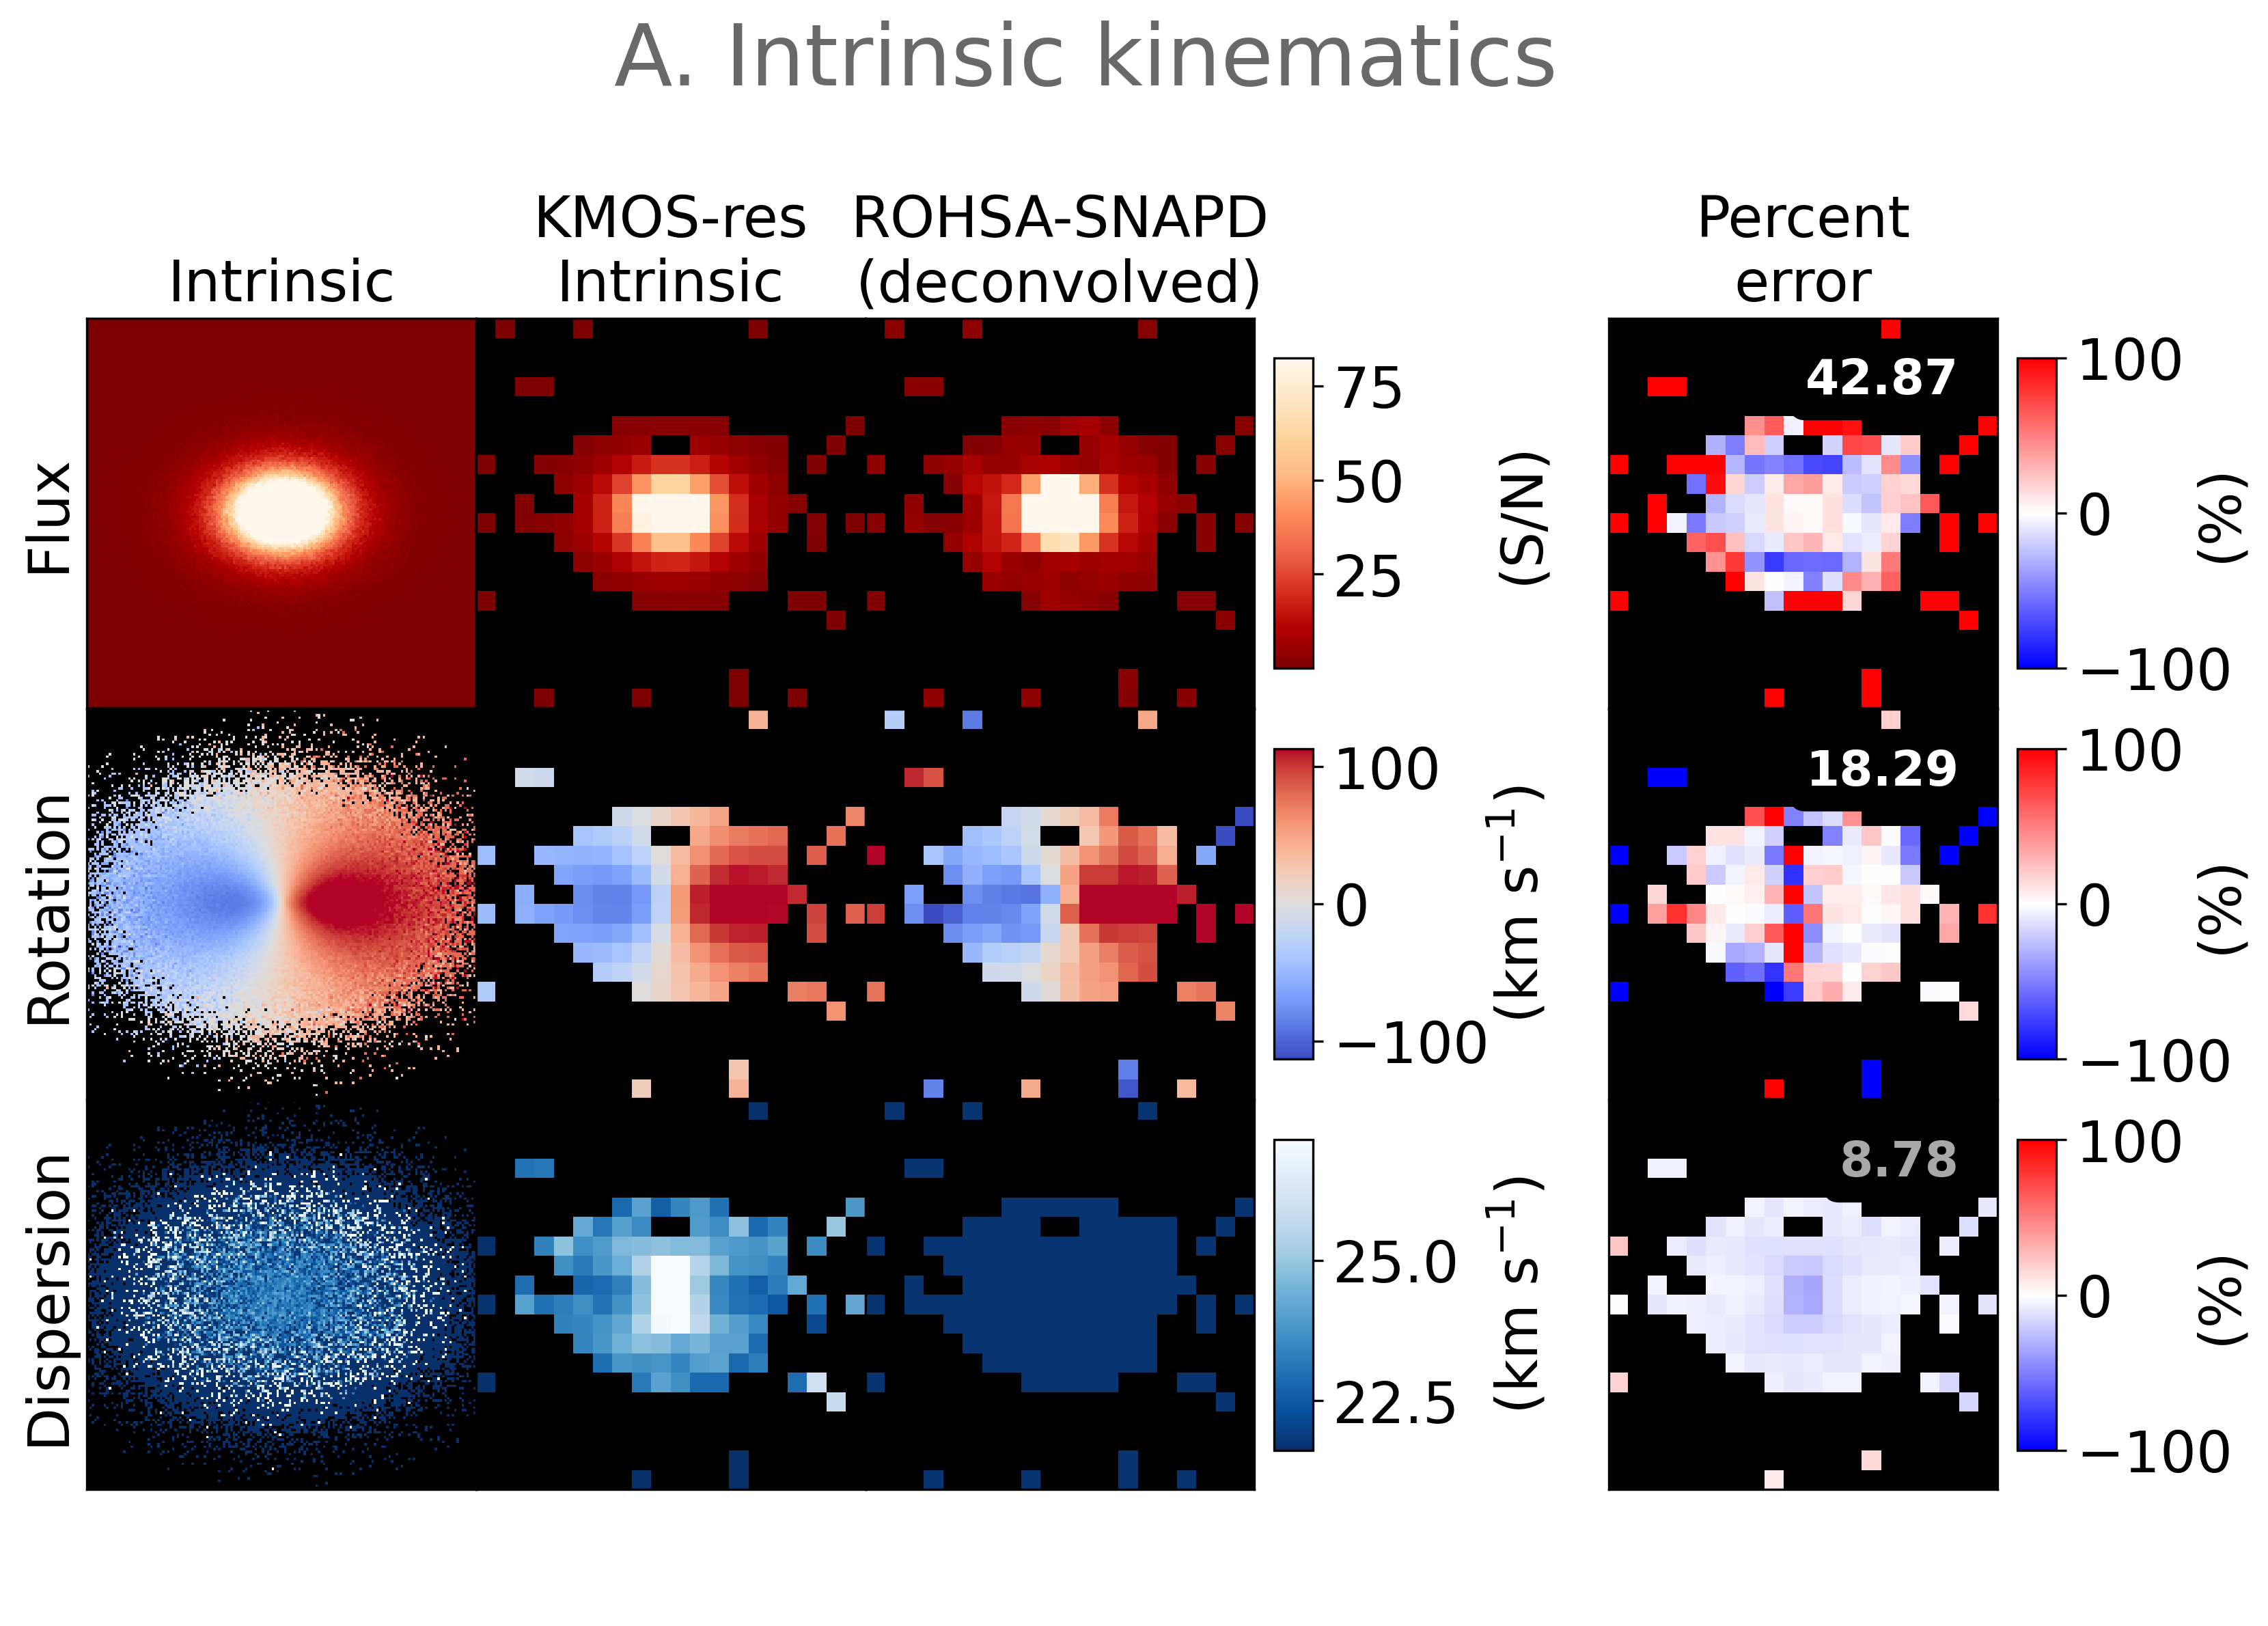

In [9]:
SN_cut = 1

# get observed data
simcube_hdul = fits.open(hdul_save_path)
# get observed data
observed_data = copy.deepcopy(simcube_hdul['DATA'].data) / simcube_hdul['DATA'].header['FLX_SCL']
observed_rms_error = copy.deepcopy(simcube_hdul['RMS'].data) / simcube_hdul['DATA'].header['FLX_SCL']
# create RMS map
rms_map = np.sqrt(np.nansum(copy.deepcopy(observed_rms_error) ** 2, axis=0))


# get the fit ROHSA parameters from the optimiser output
params = opt_output['x']

flux_mu_params = params[:-1]
# reshape the flux and mu maps
flux_mu_param_maps = np.reshape(flux_mu_params, (2, np.shape(observed_data)[1], np.shape(observed_data)[2]))
# then create the sigma map
sig_param_map = np.full((np.shape(observed_data)[1], np.shape(observed_data)[2]), params[-1])
# append to make param_maps
RSNAPD_maps = np.append(flux_mu_param_maps, [sig_param_map], axis=0)

# also generate convolved kinematic maps
# first make a convolved cube
jnp_psf_image = jnp.array(simcube_hdul['PSF'].data).astype(jnp.float64)
jnp_RSNAPD_maps = jnp.array(RSNAPD_maps).astype(jnp.float64)
jnp_observed_data = jnp.array(observed_data).astype(jnp.float64)
convolved_model = kin_maps_to_convolved_cube(jnp_RSNAPD_maps, sigma_LSF_kms/obs_vstep_kms, jnp_psf_image, jnp_observed_data, param_map_oversample_factor)
# get the convolved model kinematic maps
convolved_model_maps = np.array(fit_gauss_cube(copy.deepcopy(convolved_model), return_flux_map=True, flux_scale_fact=None))

# also get kinematic maps from the observed data, accounting for the rms error
observed_maps = np.array(fit_gauss_cube_w_errs(copy.deepcopy(observed_data),copy.deepcopy(observed_rms_error), return_flux_map=True,flux_scale_fact=None))

# also make kinematic maps of the high resultion model
high_res_intrin_cube = simcube_hdul['INTRINSIC_DATA'].data
# get moment maps
high_res_intrin_flux_map = moment_n(cube=high_res_intrin_cube, n=0, vstep_kms=obs_vstep_kms, vrot_zeropt=0)
high_res_intrin_vrot_map = moment_n(cube=high_res_intrin_cube, n=1, vstep_kms=obs_vstep_kms, vrot_zeropt=0)
high_res_intrin_disp_map = moment_n(cube=high_res_intrin_cube, n=2, vstep_kms=obs_vstep_kms, vrot_zeropt=0)
intrinsic_maps = np.array([high_res_intrin_flux_map,high_res_intrin_vrot_map,high_res_intrin_disp_map])

# also make kinematic maps of the binned resultion model
binned_res_intrin_cube = simcube_hdul['BINNED_INTRINSIC_DATA'].data
# get moment maps
binned_res_intrin_flux_map = moment_n(cube=binned_res_intrin_cube, n=0, vstep_kms=obs_vstep_kms, vrot_zeropt=0)
binned_res_intrin_vrot_map = moment_n(cube=binned_res_intrin_cube, n=1, vstep_kms=obs_vstep_kms, vrot_zeropt=0)
binned_res_intrin_disp_map = moment_n(cube=binned_res_intrin_cube, n=2, vstep_kms=obs_vstep_kms, vrot_zeropt=0)
binned_intrinsic_maps = np.array([binned_res_intrin_flux_map,binned_res_intrin_vrot_map,binned_res_intrin_disp_map])


# because this is simulated data, make the rotational velocity zero value be the centre of the cube
vrot_zeropt = (observed_data.shape[0] / 2 - 0.5) * obs_vstep_kms

# scale the maps from pixel units into physical units
RSNAPD_maps = flux_mu_sig_to_flux_vrot_vdisp(RSNAPD_maps, vstep_kms=obs_vstep_kms, vrot_zeropt=vrot_zeropt, flux_scale_fact=simcube_hdul['DATA'].header['FLX_SCL'])
convolved_model_maps = flux_mu_sig_to_flux_vrot_vdisp(convolved_model_maps, vstep_kms=obs_vstep_kms, vrot_zeropt=vrot_zeropt, flux_scale_fact=simcube_hdul['DATA'].header['FLX_SCL'])
# don't need to rescale flux of observed maps as it was already done to the data
observed_maps = flux_mu_sig_to_flux_vrot_vdisp(observed_maps, vstep_kms=obs_vstep_kms, vrot_zeropt=vrot_zeropt, flux_scale_fact=None)

# first make convovled and deconvolved model S/N maps
convovled_SN_map = copy.deepcopy(convolved_model_maps[0] / copy.deepcopy(rms_map))
deconvovled_SN_map = copy.deepcopy(RSNAPD_maps[0] / copy.deepcopy(rms_map))

# nan outside the SN mask
RSNAPD_maps[:,deconvovled_SN_map <= SN_cut] = float('nan')
binned_intrinsic_maps[:,deconvovled_SN_map <= SN_cut] = float('nan')
convolved_model_maps[:,convovled_SN_map <= SN_cut] = float('nan')
observed_maps[:,convovled_SN_map <= SN_cut] = float('nan')

# also convert the flux maps into S/N maps
RSNAPD_maps[0,:,:] /= rms_map
binned_intrinsic_maps[0,:,:] /= rms_map
convolved_model_maps[0,:,:] /= rms_map
observed_maps[0,:,:] /= rms_map


# subtract vrot_zeropt
binned_intrinsic_maps[1,:,:] -= vrot_zeropt
intrinsic_maps[1,:,:] -= vrot_zeropt


# make first figure of just the intrinsic maps
fig,ax = plt.subplots(3, 11,width_ratios=[0.1,1,1,1,0.05,0.1,0.76,1,0.05,0.1,0.35],dpi=300,figsize=(13.5, 8.89))

ax[0, 0].text(0.0, 0.5, 'Flux', ha='center', va='center', rotation=90, fontsize=20)
ax[1, 0].text(0.0, 0.5, 'Rotation', ha='center', rotation=90, va='center', fontsize=20)
ax[2, 0].text(0.0, 0.5, 'Dispersion', ha='center', rotation=90, va='center', fontsize=20)

# add column titles in first row
ax[0,1].set_title('Intrinsic',fontsize=20)
ax[0,2].set_title('KMOS-res\nIntrinsic',fontsize=20)
ax[0,3].set_title('ROHSA-SNAPD\n(deconvolved)',fontsize=20)
ax[0,7].set_title('Percent\nerror', fontsize=20)

# define colorbar bounds
intrinsic_flux_bounds = np.array([np.nanpercentile(binned_intrinsic_maps[0][binned_intrinsic_maps[0] > 0],5),np.nanpercentile(binned_intrinsic_maps[0][binned_intrinsic_maps[0] > 0],95)])
# make intrinsic_rot_bounds symmetric
max_intrinsic_rot = np.nanmax(np.abs(np.array([np.nanpercentile(binned_intrinsic_maps[1][binned_intrinsic_maps[0] > 0],5),np.nanpercentile(binned_intrinsic_maps[1][binned_intrinsic_maps[0] > 0],95)])))
intrinsic_rot_bounds = np.array([-max_intrinsic_rot,max_intrinsic_rot])
intrinsic_disp_bounds = np.array([np.nanpercentile(binned_intrinsic_maps[2][binned_intrinsic_maps[0] > 0],5),np.nanpercentile(binned_intrinsic_maps[2][binned_intrinsic_maps[0] > 0],95)])
intrin_map_bounds = np.array([intrinsic_flux_bounds,intrinsic_rot_bounds,intrinsic_disp_bounds])


for map_idx in range(3):
    if map_idx == 0:
        chosen_cmap = nan_cmap()
        units_str = '(S/N)'
    elif map_idx == 1:
        chosen_cmap = nan_diverging_cmap()
        units_str = r'(km s$^{-1}$)'
    elif map_idx == 2:
        chosen_cmap = nan_cmap_2()
        units_str = r'(km s$^{-1}$)'
    
    # plot the intrinsic data in the 1st column
    if map_idx == 0:
        intrin_im = ax[map_idx, 1].imshow(intrinsic_maps[map_idx], origin='lower', cmap=chosen_cmap,vmin=np.nanpercentile(intrinsic_maps[map_idx][intrinsic_maps[0] > 0],5),vmax=np.nanpercentile(intrinsic_maps[map_idx][intrinsic_maps[0] > 0],95),extent=(0,RSNAPD_maps[0].shape[1],0,RSNAPD_maps[0].shape[0]))
    else:
        intrin_im = ax[map_idx, 1].imshow(intrinsic_maps[map_idx], origin='lower', cmap=chosen_cmap,vmin=intrin_map_bounds[map_idx, 0], vmax=intrin_map_bounds[map_idx, 1],extent=(0,RSNAPD_maps[0].shape[1],0,RSNAPD_maps[0].shape[0]))


    
    # plot the binned intrinsic data in the 2nd column
    binned_intrin_im = ax[map_idx, 2].imshow(binned_intrinsic_maps[map_idx], origin='lower', cmap=chosen_cmap,vmin=intrin_map_bounds[map_idx,0],vmax=intrin_map_bounds[map_idx,1],extent=(0,RSNAPD_maps[0].shape[1],0,RSNAPD_maps[0].shape[0]))
    # plot the RSNAPD (deconvolved) data in the 3rd column
    RSNAPD_im = ax[map_idx, 3].imshow(RSNAPD_maps[map_idx], origin='lower', cmap=chosen_cmap,vmin=intrin_map_bounds[map_idx,0],vmax=intrin_map_bounds[map_idx,1],extent=(0,RSNAPD_maps[0].shape[1],0,RSNAPD_maps[0].shape[0]))

    # add the maps colourbar
    intrin_cbar = plt.colorbar(RSNAPD_im, cax=ax[map_idx, 5].inset_axes([0.0, 0.25, 1.0, 0.5]))
    intrin_cbar.ax.tick_params(labelsize=20)
    # add colourbar units
    ax[map_idx, 6].text(0.8, 0.5, units_str, ha='right', va='center', rotation=90, fontsize=20)

    # add residuals
    intrin_residual = (RSNAPD_maps[map_idx] - binned_intrinsic_maps[map_idx]) / binned_intrinsic_maps[map_idx] * 100
    intrin_resid_vmin = -100
    intrin_resid_vmax = 100
    intrin_res_im = ax[map_idx, 7].imshow(intrin_residual, origin='lower', cmap=nan_diverging_residual_cmap(), vmin=intrin_resid_vmin, vmax=intrin_resid_vmax,extent=(0,RSNAPD_maps[0].shape[1],0,RSNAPD_maps[0].shape[0]))

    # add median residuals as text
    if map_idx != 2:
        text_colour = 'w'
    else:
        text_colour = 'darkgrey'
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='k', alpha=1)
    ax[map_idx, 7].text(intrin_residual.shape[1] - 2, intrin_residual.shape[0] - 2, f'{np.nanmedian(np.abs(intrin_residual)):.2f}', ha='right', va='top',fontsize=17, color=text_colour, fontweight='bold',bbox=props)

    # add the residual colourbar
    resid_cbar = plt.colorbar(intrin_res_im, cax=ax[map_idx, 9].inset_axes([0.0, 0.25, 1.0, 0.5]))
    resid_cbar.ax.tick_params(labelsize=20)
    # add colourbar units
    ax[map_idx, 10].text(1.0, 0.5, '(%)', ha='left', va='center', rotation=90, fontsize=20)

    for ax_num in range(11):
        if ax_num in [0,4,5,6,8,9,10]:
            ax[map_idx, ax_num].axis('off')
        else:
            ax[map_idx, ax_num].get_xaxis().set_visible(False)
            ax[map_idx, ax_num].get_yaxis().set_visible(False)

    # set no wspace
    plt.subplots_adjust(wspace=0,hspace=-0.37)

    fig.suptitle('A. Intrinsic kinematics',x=0.5,y=0.98, fontsize=30,va='top',c='dimgrey')

plt.show()


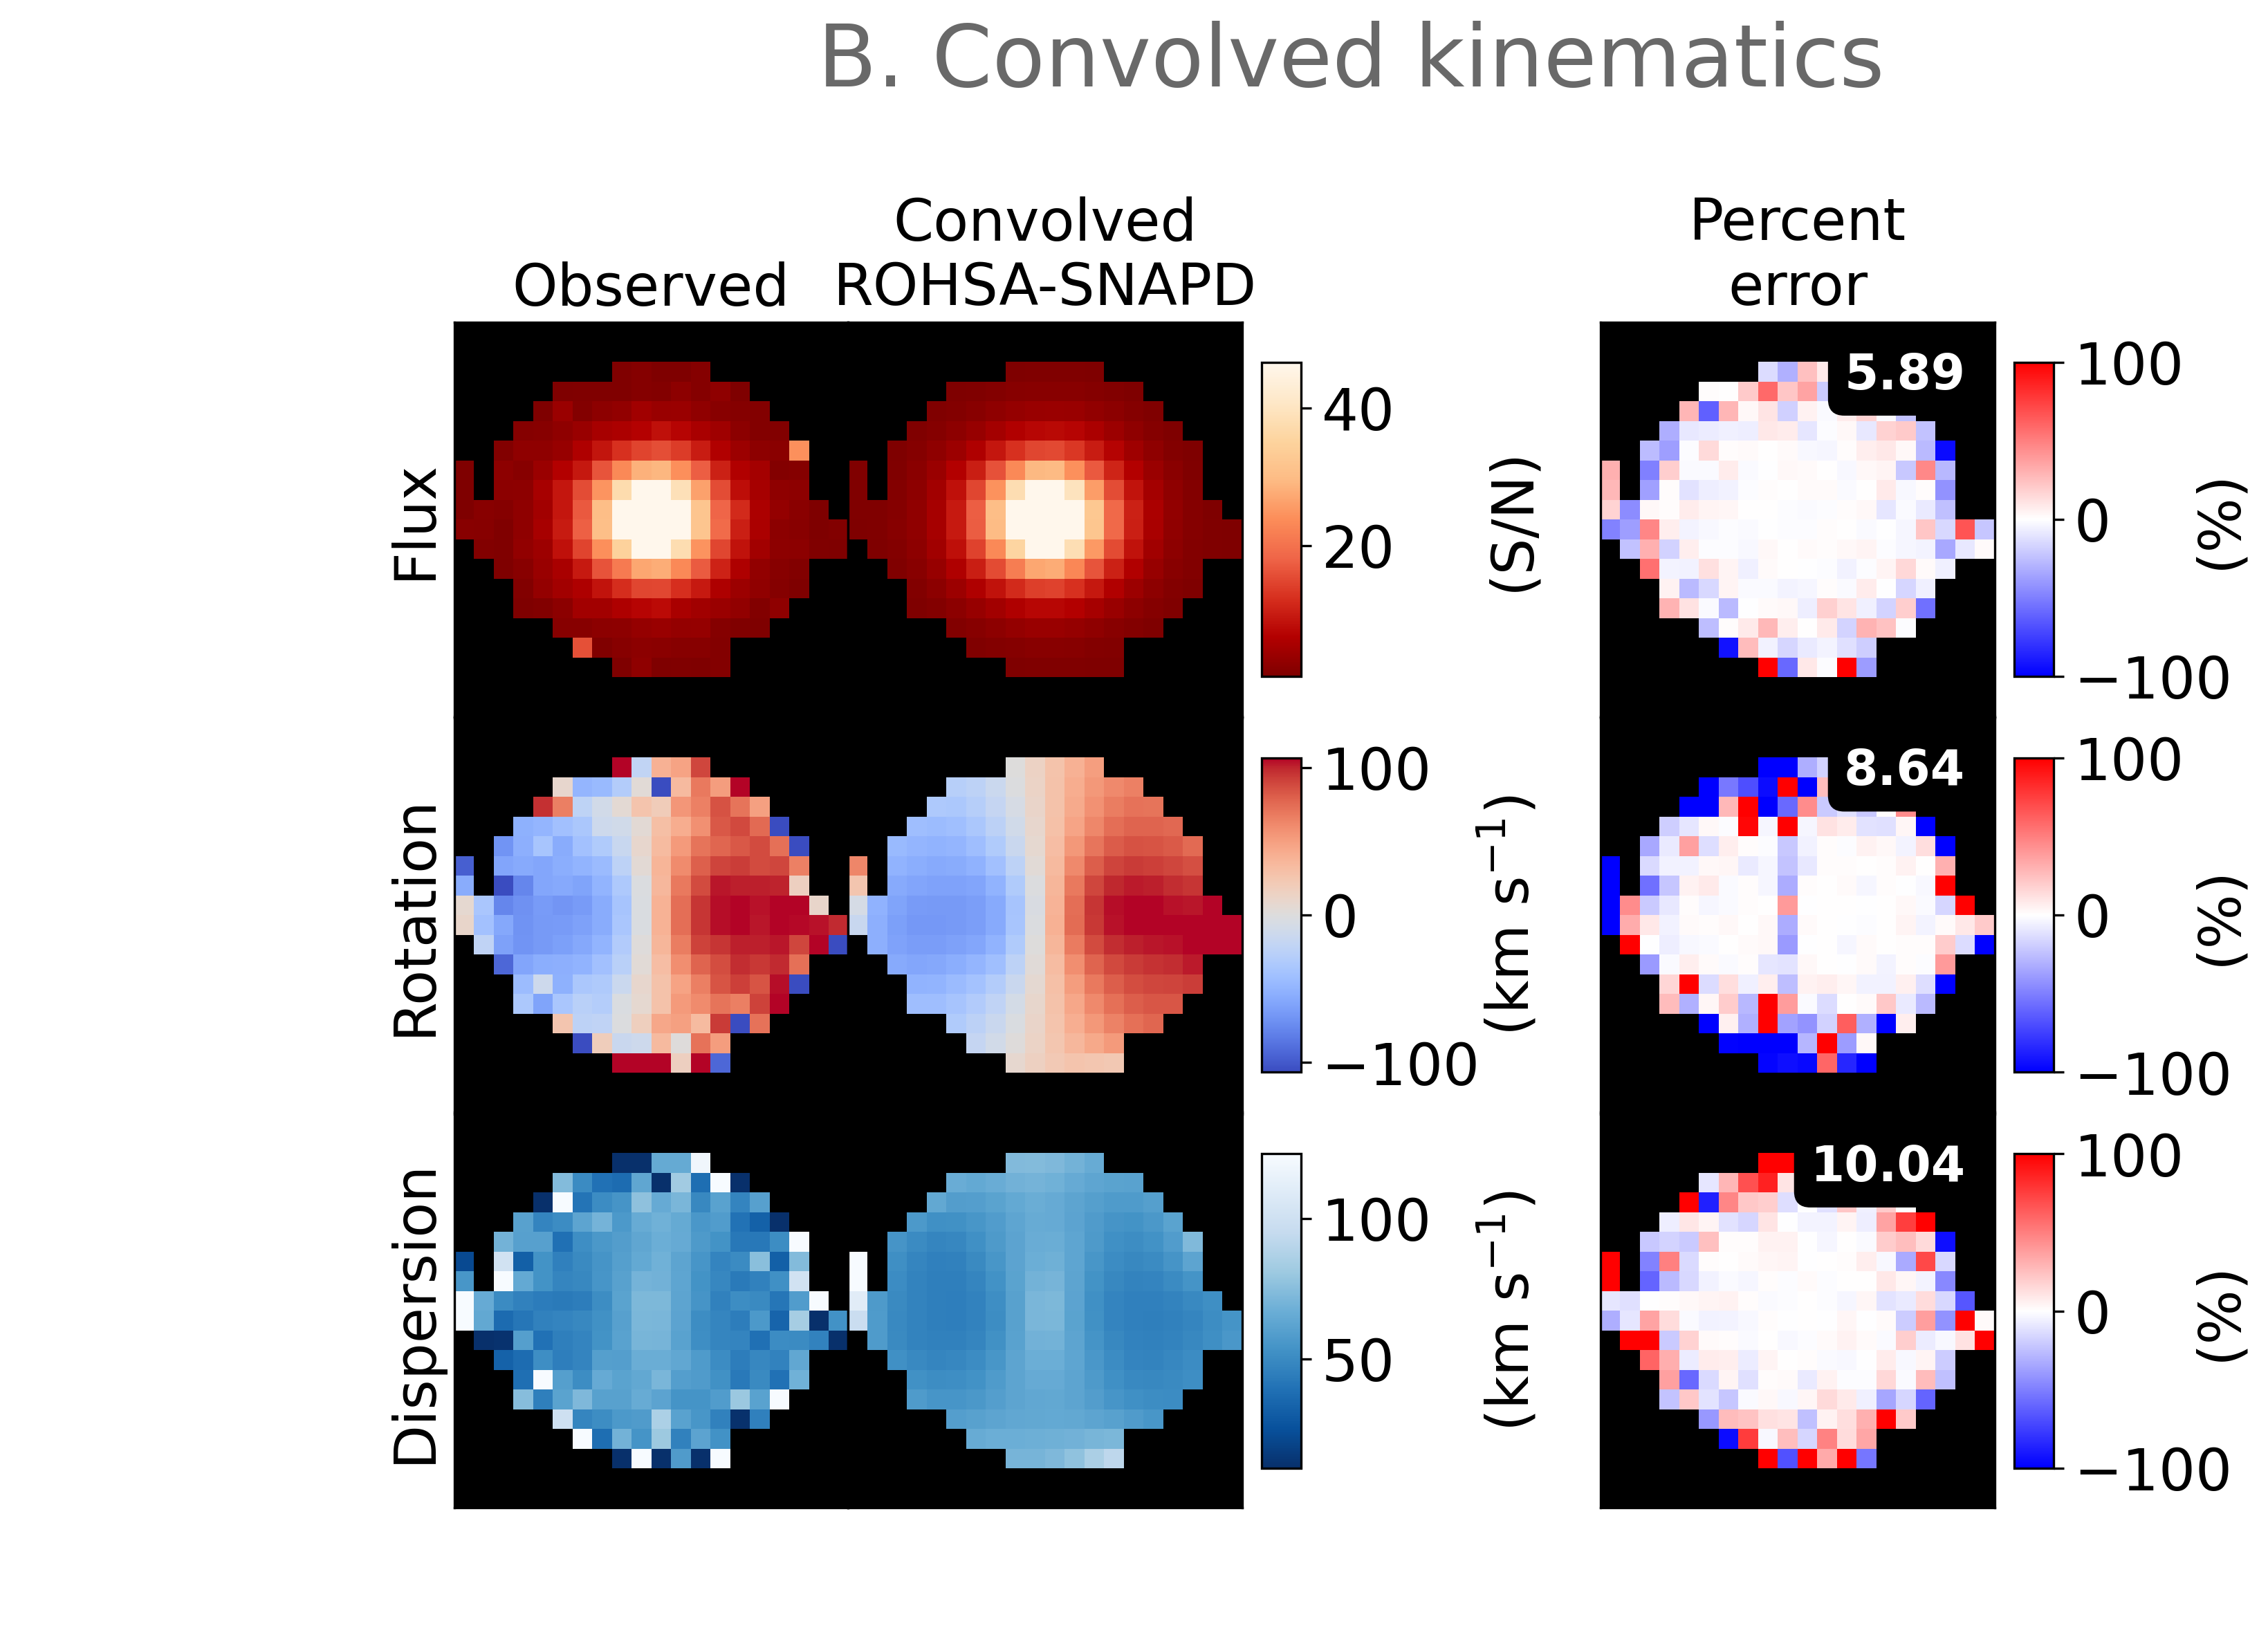

In [8]:
# make second figure of just the convolved maps
fig1, ax1 = plt.subplots(3, 11,width_ratios=[1,0.1,1,1,0.05,0.1,0.76,1,0.05,0.1,0.35],dpi=300,figsize=(13.5, 8.89))

# add map names in first column
ax1[0, 1].text(0.0, 0.5, 'Flux', ha='center', va='center', rotation=90, fontsize=20)
ax1[1, 1].text(0.0, 0.5, 'Rotation', ha='center', rotation=90, va='center', fontsize=20)
ax1[2, 1].text(0.0, 0.5, 'Dispersion', ha='center', rotation=90, va='center', fontsize=20)

# add column titles in first row
ax1[0,2].set_title('Observed',fontsize=20)
ax1[0,3].set_title('Convolved\nROHSA-SNAPD',fontsize=20)
ax1[0,7].set_title('Percent\nerror', fontsize=20)

convolved_flux_bounds = np.array([np.nanpercentile(observed_maps[0], 5), np.nanpercentile(observed_maps[0], 95)])
# make intrinsic_rot_bounds symmetric
max_convolved_rot = np.nanmax(np.abs(np.array([np.nanpercentile(observed_maps[1], 5), np.nanpercentile(observed_maps[1], 95)])))
convolved_rot_bounds = np.array([-max_convolved_rot, max_convolved_rot])
convolved_disp_bounds = np.array([np.nanpercentile(observed_maps[2], 5), np.nanpercentile(observed_maps[2], 95)])
convolved_map_bounds = np.array([convolved_flux_bounds, convolved_rot_bounds, convolved_disp_bounds])

for map_idx in range(3):
    if map_idx == 0:
        chosen_cmap = nan_cmap()
        units_str = '(S/N)'
    elif map_idx == 1:
        chosen_cmap = nan_diverging_cmap()
        units_str = r'(km s$^{-1}$)'
    elif map_idx == 2:
        chosen_cmap = nan_cmap_2()
        units_str = r'(km s$^{-1}$)'
    
    # plot the observed data in the 2nd column
    conv_im = ax1[map_idx, 2].imshow(observed_maps[map_idx], origin='lower', cmap=chosen_cmap,vmin=convolved_map_bounds[map_idx, 0], vmax=convolved_map_bounds[map_idx, 1])

    # plot the convolved RSNAPD data in the 3rd column
    conv_RSNAPD_im = ax1[map_idx, 3].imshow(convolved_model_maps[map_idx], origin='lower', cmap=chosen_cmap,vmin=convolved_map_bounds[map_idx, 0], vmax=convolved_map_bounds[map_idx, 1])

    # add the maps colourbar
    conv_cbar = plt.colorbar(conv_RSNAPD_im, cax=ax1[map_idx, 5].inset_axes([0.0, 0.25, 1.0, 0.5]))
    conv_cbar.ax.tick_params(labelsize=20)
    # add colourbar units
    ax1[map_idx, 6].text(0.8, 0.5, units_str, ha='right', va='center', rotation=90, fontsize=20)

    # add residuals
    conv_residual = (convolved_model_maps[map_idx] - observed_maps[map_idx]) / observed_maps[map_idx] * 100


    conv_resid_vmin = -100
    conv_resid_vmax = 100
    conv_res_im = ax1[map_idx, 7].imshow(conv_residual, origin='lower', cmap=nan_diverging_residual_cmap(), vmin=conv_resid_vmin, vmax=conv_resid_vmax)

    # add median residuals as text
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='k', alpha=1)
    ax1[map_idx, 7].text(conv_residual.shape[1] - 2, conv_residual.shape[0]-2, f'{np.nanmedian(np.abs(conv_residual)):.2f}', ha='right', va='top', fontsize=17,color='w',fontweight='bold',bbox=props)

    # add the residual colourbar
    resid_cbar = plt.colorbar(conv_res_im, cax=ax1[map_idx, 9].inset_axes([0.0, 0.25, 1.0, 0.5]))
    resid_cbar.ax.tick_params(labelsize=20)
    # add colourbar units
    ax1[map_idx, 10].text(1.0, 0.5, '(%)', ha='left', va='center', rotation=90, fontsize=20)

    for ax_num in range(11):
        if ax_num in [0,1,4,5,6,8,9,10 ]:
            ax1[map_idx, ax_num].axis('off')
        else:
            ax1[map_idx, ax_num].get_xaxis().set_visible(False)
            ax1[map_idx, ax_num].get_yaxis().set_visible(False)

# set no wspace
plt.subplots_adjust(wspace=0,hspace=-0.37)

fig1.suptitle('B. Convolved kinematics', x=0.6,y=0.98, fontsize=30,va='top',c='dimgrey')

plt.show()